# Q1: Mall of America – Customer Behavioral Segmentation



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
import warnings; warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.ticker import PercentFormatter

In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
FILE_PATH = "moa_customer_segments.xlsx"
df = pd.read_excel(FILE_PATH, sheet_name=0)

In [ ]:
print("Raw shape:", df.shape)
print("Columns:", list(df.columns))

Raw shape: (7705, 31)
Columns: ['device', 'session_date', 'apple_flag', 'entry_time', 'exit_time', 'duration', 'time_0_1', 'time_0', 'time_1', 'time_2', 'time_3', 'time_4', 'time_2_E', 'time_2_N', 'time_2_NE', 'time_2_NEx', 'time_2_NW', 'time_2_S', 'time_2_SE', 'time_2_SW', 'time_2_W', 'time_3_E', 'time_3_N', 'time_3_NE', 'time_3_NEx', 'time_3_NW', 'time_3_S', 'time_3_SE', 'time_3_SW', 'time_3_W', 'employee_flag']


## Q1 (1) Filter out employees and short-duration visitors


In [ ]:
# Normalize employee_flag to boolean
emp_col = "employee_flag"
if emp_col in df.columns:
    # Coerce to boolean (1/0 or 'Y'/'N')
    df[emp_col] = df[emp_col].astype(str).str.strip().str.upper().isin(["1","Y","TRUE","T"])
else:
    df[emp_col] = False  # if absent, assume all are visitors

if "duration" not in df.columns:
    raise ValueError("Expected 'duration' column (seconds) not found.")

# After filtering out for duration (less than 30 mins) and employees, we will save the cleaned dataset
filtered = df.loc[(~df[emp_col]) & (df["duration"] >= 1800)].copy()
print("After filtering:", filtered.shape)

After filtering: (4832, 31)


## Q1 (2) Cluster customers based on time spent across floors

In [ ]:
# Select only floor columns (already filtered dataset)
floor_cols = ["time_0", "time_1", "time_2", "time_3", "time_4"]

In [ ]:
# Ensure numeric & non-negative
for col in floor_cols:
    filtered[col] = pd.to_numeric(filtered[col], errors="coerce").clip(lower=0).fillna(0)

In [ ]:
#  Convert to percentages
floor_total = filtered[floor_cols].sum(axis=1).replace(0, np.nan)
floor_pct = filtered[floor_cols].div(floor_total, axis=0) * 100
floor_pct = floor_pct.fillna(0)
floor_pct.columns = [f"{c}_pct" for c in floor_cols]

X_floor = floor_pct.values

In [ ]:
# Range of k values
ks = list(range(2, 11))
inertias, silhouettes = [], []

# Loop through each k
for k in ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels_k = km.fit_predict(X_floor)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_floor, labels_k))

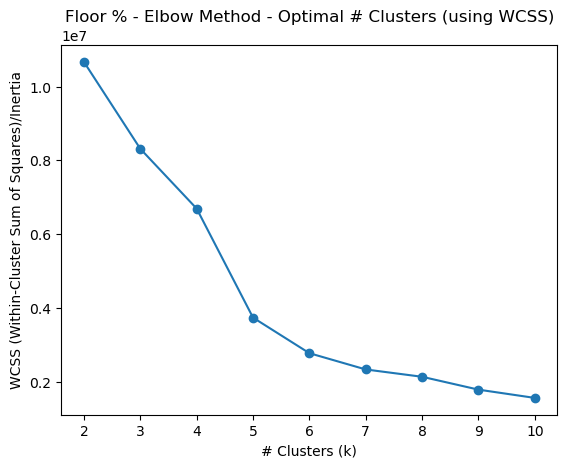

In [ ]:
# Elbow plot
plt.plot(ks, inertias, marker="o")
plt.title("Floor % - Elbow Method - Optimal # Clusters (using WCSS)")
plt.xlabel("# Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)/Inertia")
plt.show()

The elbow curve has a noticeable bend at k = 5.
This suggests that five is the best number of clusters.
After this point, adding more clusters only slightly improves the model fit.

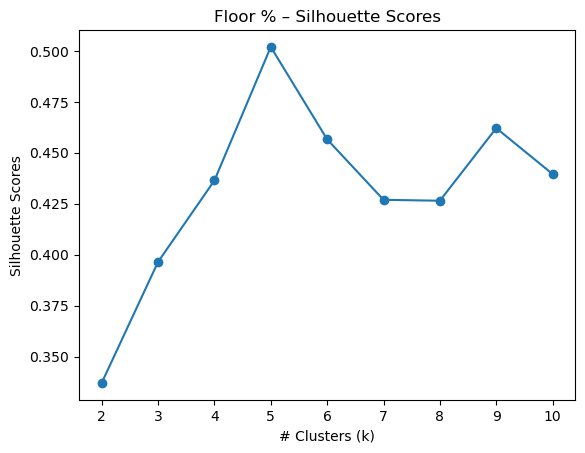

In [ ]:
# Silhouette plot
plt.plot(ks, silhouettes, marker="o")
plt.title("Floor % – Silhouette Scores")
plt.xlabel("# Clusters (k)")
plt.ylabel("Silhouette Scores")
plt.show()

The silhouette score is highest at k = 5. This shows that 5 is the best number of clusters. It suggests strong cohesion within the clusters and clear separation between them.

In [ ]:
# Identifying the optimal # clusters using silhouette scores
best_k = ks[int(np.argmax(silhouettes))]
print("Best k (by silhouette):", best_k)

Best k (by silhouette): 5


In [ ]:
# 3) Final KMeans using best_k
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
labels = kmeans.fit_predict(X_floor)
filtered["floor_cluster"] = labels

In [ ]:
# 4) Cluster profiling (mean % per floor)
cluster_profile = floor_pct.copy()
cluster_profile["cluster"] = labels
cluster_means = cluster_profile.groupby("cluster").mean(numeric_only=True)

print("\nCluster means (% time by floor):")
print(cluster_means.round(1))


Cluster means (% time by floor):
         time_0_pct  time_1_pct  time_2_pct  time_3_pct  time_4_pct
cluster                                                            
0               0.8        22.1        58.1        16.7         2.1
1               1.3        16.6         9.6        70.6         1.9
2               1.2        10.9         5.9        11.1        70.9
3              89.0         5.0         2.0         3.3         0.7
4               1.0        75.5         8.8        13.0         1.7


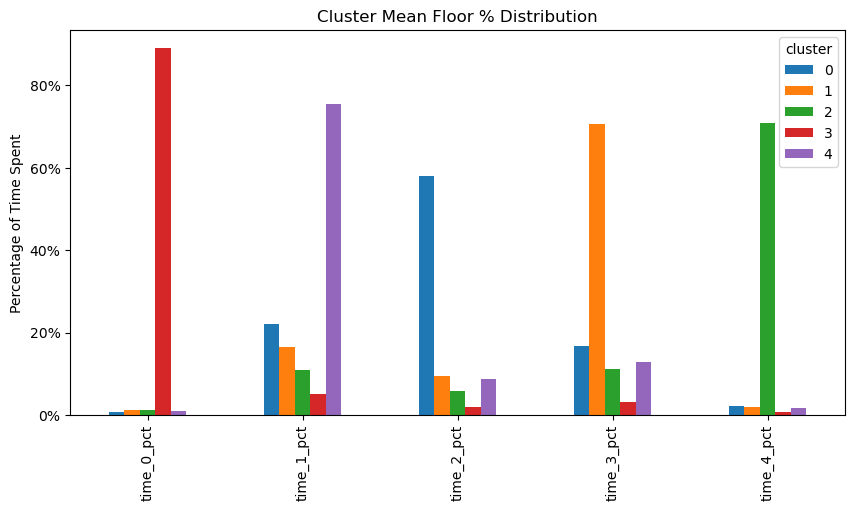

In [ ]:
# Bar chart of mean profiles
cluster_means.T.plot(kind="bar", figsize=(10,5))
plt.title("Cluster Mean Floor % Distribution")
plt.ylabel("Percentage of Time Spent")
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
plt.show()

Each cluster has a clearly dominant floor. For instance, Cluster 0 focuses on Level 2, while Cluster 3 focuses on Level 0. This shows that visitor groups are well-separated based on their floor usage patterns.

## Q1 (3) Section-level sub-clustering





In [ ]:
target_cluster = 0
target_floor = "time_2"


In [ ]:
print("\n[Fixed choice] Sub-clustering Cluster:", target_cluster, "| Floor:", target_floor)


[Fixed choice] Sub-clustering Cluster: 0 | Floor: time_2


In [ ]:
# Guard: ensure target cluster exists
if target_cluster not in filtered["floor_cluster"].unique():
    raise ValueError(f"Chosen cluster {target_cluster} not found in floor_cluster labels.")

In [ ]:
# Guard: show dominance check (info only)
if f"{target_floor}_pct" in cluster_means.columns:
    dom_pct = cluster_means.loc[target_cluster, f"{target_floor}_pct"]
    print(f"Info: In cluster {target_cluster}, {target_floor} mean share = {dom_pct:.1f}%")
else:
    print(f"Info: {target_floor}_pct not in cluster_means columns; continuing with fixed choice.")

sub_df = filtered.loc[filtered["floor_cluster"] == target_cluster].copy()

Info: In cluster 0, time_2 mean share = 58.1%


In [ ]:
# Section columns for Level 2 (validate availability)
sections_lvl2 = [
    "time_2_E","time_2_N","time_2_NE","time_2_NEx","time_2_NW",
    "time_2_S","time_2_SE","time_2_SW","time_2_W"
]
sec_cols = [c for c in sections_lvl2 if c in sub_df.columns]
if len(sec_cols) < 3:
    raise ValueError("Not enough Level 2 section columns found. Check column names like time_2_E, time_2_N, ... time_2_W.")

In [ ]:
# Section % features
for c in sec_cols:
    sub_df[c] = pd.to_numeric(sub_df[c], errors="coerce").clip(lower=0).fillna(0)
sec_sum = sub_df[sec_cols].sum(axis=1).replace(0, np.nan)
sec_pct = sub_df[sec_cols].div(sec_sum, axis=0) * 100
sec_pct = sec_pct.fillna(0)
sec_pct.columns = [f"{c}_pct" for c in sec_cols]
X_sec = sec_pct.values

In [ ]:
print("Section columns used:", sec_cols)
print("Shape of section-level dataset:", sec_pct.shape)

Section columns used: ['time_2_E', 'time_2_N', 'time_2_NE', 'time_2_NEx', 'time_2_NW', 'time_2_S', 'time_2_SE', 'time_2_SW', 'time_2_W']
Shape of section-level dataset: (1054, 9)


In [ ]:
# preview the first few normalized records
sec_pct.head()

,time_2_E_pct,time_2_N_pct,time_2_NE_pct,time_2_NEx_pct,time_2_NW_pct,time_2_S_pct,time_2_SE_pct,time_2_SW_pct,time_2_W_pct
1,7.303823,0.000000,1.690141,0.0,0.000000,3.480885,8.490946,53.581489,25.452716
5,0.000000,0.000000,0.000000,0.0,0.000000,24.543081,51.592689,23.864230,0.000000
7,58.209737,4.658873,5.391729,0.0,21.758855,0.000000,1.483162,3.542139,4.955505
8,32.193615,0.000000,0.000000,0.0,0.000000,57.610711,0.000000,0.000000,10.195675
9,0.000000,95.532694,4.467306,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
ks2 = list(range(2, 8))
inertias2, silhouettes2 = [], []
for k in ks2:
    km2 = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels2_k = km2.fit_predict(X_sec)
    inertias2.append(km2.inertia_)
    silhouettes2.append(silhouette_score(X_sec, labels2_k))

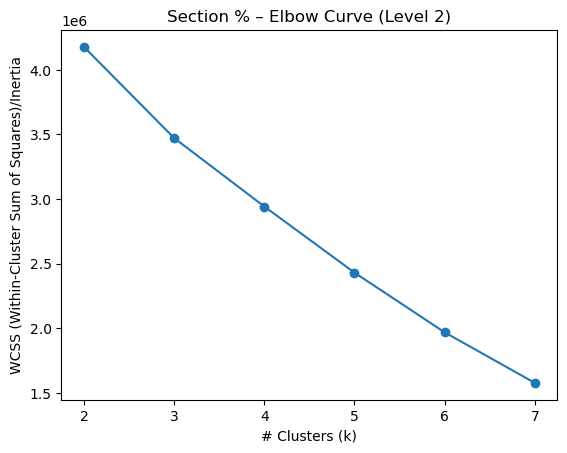

In [ ]:
plt.plot(ks2, inertias2, marker="o");
plt.title("Section % – Elbow Curve (Level 2)")
plt.xlabel("# Clusters (k)");
plt.ylabel("WCSS (Within-Cluster Sum of Squares)/Inertia");
plt.show()

The elbow curve for Level 2 sections shows a clear bend around k = 5. This suggests that five sub-clusters best capture visitor behavior on this floor. After this point, inertia gradually decreases and provides little extra benefit.

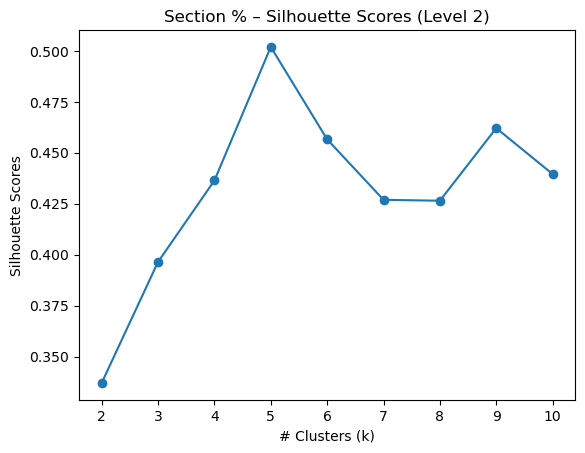

In [ ]:
plt.plot(ks, silhouettes, marker="o")
plt.title("Section % – Silhouette Scores (Level 2)")
plt.xlabel("# Clusters (k)")
plt.ylabel("Silhouette Scores")
plt.show()

The silhouette score peaks at k = 5.
This shows that five section-level sub-clusters offer the best balance of cohesion and separation.
This confirms the existence of five distinct visitor behavior patterns within Level 2.

In [ ]:
best_k = ks[np.argmax(silhouettes)]
print("Best k (by silhouette):", best_k)

Best k (by silhouette): 5


In [ ]:
# Final clustering
kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
labels = kmeans.fit_predict(X_sec)
sec_profile = sec_pct.copy()
sec_profile["section_cluster"] = labels

In [ ]:
sec_means = sec_profile.groupby("section_cluster").mean()
print("\nSection sub-cluster means (% time by section):")
print(sec_means.round(1))


Section sub-cluster means (% time by section):
                 time_2_E_pct  time_2_N_pct  time_2_NE_pct  time_2_NEx_pct  \
section_cluster                                                              
0                         7.1           6.9           45.2             1.4   
1                         6.2          26.5            4.2             3.1   
2                         5.2           4.0            2.4             0.7   
3                        72.2           4.0            5.4             0.0   
4                         4.6           3.9            3.0             1.9   

                 time_2_NW_pct  time_2_S_pct  time_2_SE_pct  time_2_SW_pct  \
section_cluster                                                              
0                          3.8           3.6           23.7            3.6   
1                         19.2          24.0            4.4            5.5   
2                          3.8           5.3            4.0           67.5   
3              

<Figure size 1200x600 with 0 Axes>

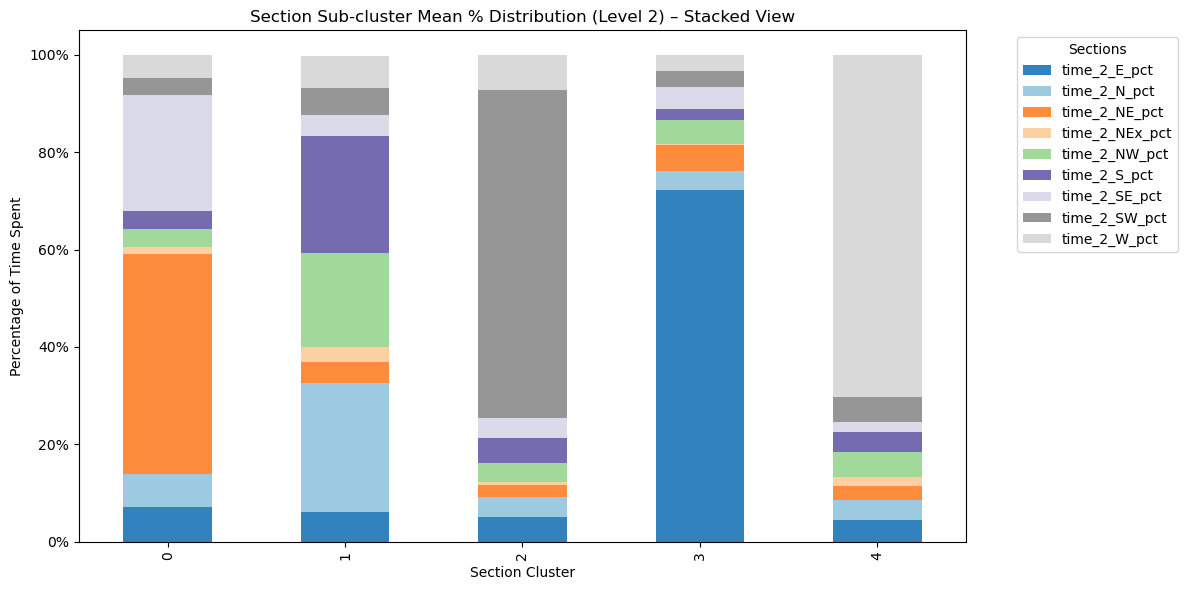

In [ ]:
#  Stacked Bar Chart
plt.figure(figsize=(12,6))
sec_means.plot(kind="bar", stacked=True, figsize=(12,6), colormap="tab20c")

plt.title("Section Sub-cluster Mean % Distribution (Level 2) – Stacked View")
plt.xlabel("Section Cluster")
plt.ylabel("Percentage of Time Spent")
plt.gca().yaxis.set_major_formatter(PercentFormatter(100))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Sections")
plt.tight_layout()
plt.show()

Every section group is dominated by certain areas—e.g., Cluster 3 dominates the East section and Cluster 4 dominates the West. This indicates clear visitor preferences at Level 2, with localized attraction zones like busy store areas or dining corridors